In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Set up
import sys

sys.path.append("/home/dchen/BA_CH_EN/")

# Basics
import tensorflow as tf
import xarray as xr
import numpy as np
from scipy.stats import norm
import scipy.stats as stats
import matplotlib.pyplot as plt

# Helpful
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.DRN.DRN_load_preds import *
from src.models.DRN.DRN_load_preds_dummy_10 import *
from src.models.EMOS_local.EMOS_local_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_preds import *  # Load EMOS_global_preds
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores
from src.models.U_net.u_net_load_score import *
from src.models.U_net.u_net_load_preds import *

<IPython.core.display.Javascript object>

### 1. Load Predictions:

In [5]:
# EMOS_global
EMOS_global_t2m_preds = EMOS_global_load_preds("t2m")
EMOS_global_ws10_preds = EMOS_global_load_preds("ws10")

# EMOS_local
EMOS_local_t2m_preds = EMOS_local_load_preds("t2m")
EMOS_local_ws10_preds = EMOS_local_load_preds("ws10")

# DRN
DRN_t2m_preds = DRN_load_preds_dummy_10("t2m")
DRN_ws10_preds = DRN_load_preds_dummy_10("ws10")

# U_net
u_net_t2m_preds = u_net_load_preds("t2m")
u_net_ws10_preds = u_net_load_preds("ws10")

<IPython.core.display.Javascript object>

### 2. Load Matching Ground truth values 

In [6]:
t2m_ground_truth = ldpd.load_data_all_test_proc_denorm()[2].t2m_test_truth
ws10_ground_truth = ldpd.load_data_all_test_proc_denorm()[5].ws10_test_truth

<IPython.core.display.Javascript object>

### Function

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from scipy.stats import norm


def plot_pit_histogram(predicted_mean_sd, ground_truth, title, num_bins=50):
    assert isinstance(predicted_mean_sd, list)
    assert isinstance(ground_truth, xr.DataArray)
    assert all(isinstance(arr, np.ndarray) for arr in predicted_mean_sd)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection="3d")

    max_frequency = 0

    # Set bar width to 90% of the bin width
    bar_width = 0.9 / num_bins
    pits_list = []
    for lead_time_idx, mean_sd_array in enumerate(predicted_mean_sd):
        mean_array = np.abs(mean_sd_array[..., 0])
        sd_array = np.abs(mean_sd_array[..., 1])
        ground_truth_data = ground_truth.sel(lead_time=(lead_time_idx + 1))

        pits = norm.cdf(ground_truth_data.values, loc=mean_array, scale=sd_array)
        pits_list.append(pits)
        # Use numpy.histogram to calculate histogram values and bin edges
        hist, bin_edges = np.histogram(
            pits.flatten(), bins=np.linspace(0, 1, num_bins + 1), density=False,
        )

        # Normalize the histogram
        hist = hist / hist.sum()

        # Update the maximum frequency if necessary
        max_frequency = max(0, hist.max())

        # Plot the histogram as a 3D bar plot
        xs = bin_edges[:-1]
        ys = hist
        zs = np.full_like(
            xs, (lead_time_idx + 1) * 6
        )  # Create an array with lead time index repeated for each bin
        ax.bar(xs, ys, zs=zs, zdir="y", alpha=1, width=bar_width)

    ax.set_xlabel("PIT")
    ax.set_ylabel("Lead Time in hours")
    ax.set_zlabel("Frequency")
    ax.set_title(title)
    ax.set_zlim(0, max_frequency)
    # Change the angle of the 3D plot
    ax.view_init(15, -70)
    title_list = title.split()
    plt.savefig(
        f"/home/dchen/BA_CH_EN/reports/figures/{title_list[0]}_PIT_histogram_3D_{title_list[-1]}.pdf"
    )

    plt.show()
    return pits_list

<IPython.core.display.Javascript object>

### 1. EMOS_global

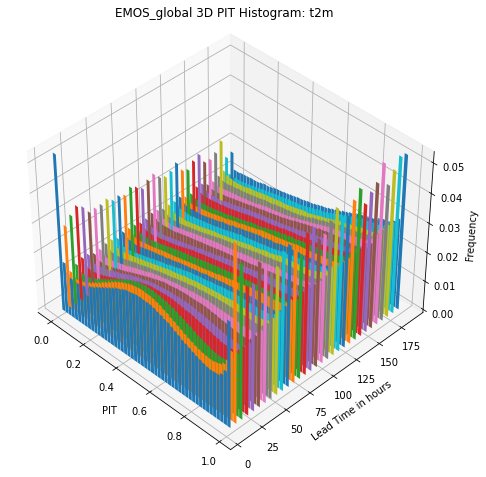

[array([[[2.11952690e-01, 1.73621011e-01, 2.39978037e-01, ...,
          4.16314488e-01, 6.49848212e-01, 6.75188057e-01],
         [2.18854937e-01, 2.08745775e-01, 2.98570273e-01, ...,
          7.28826280e-01, 7.35371167e-01, 7.26041262e-01],
         [2.42121568e-01, 2.34854685e-01, 2.30864859e-01, ...,
          7.96689555e-01, 7.55138464e-01, 7.58116554e-01],
         ...,
         [2.45672468e-01, 3.63573336e-01, 3.82817039e-01, ...,
          6.75648530e-01, 7.07795254e-01, 7.81433541e-01],
         [2.61425348e-01, 3.93717569e-01, 2.49891561e-01, ...,
          7.87367104e-01, 8.17609851e-01, 8.13548502e-01],
         [4.49748440e-01, 1.62544533e-01, 1.01382991e-02, ...,
          7.39371422e-01, 9.50963818e-01, 9.43860099e-01]],
 
        [[2.17085288e-01, 1.49142324e-01, 1.70604278e-01, ...,
          7.38366846e-01, 7.13349633e-01, 7.42403250e-01],
         [2.08611614e-01, 1.68059353e-01, 1.63588118e-01, ...,
          7.72514785e-01, 6.93134042e-01, 7.03398193e-01],
       

<IPython.core.display.Javascript object>

In [65]:
plot_pit_histogram(
    EMOS_global_t2m_preds, t2m_ground_truth, "EMOS_global 3D PIT Histogram: t2m"
)

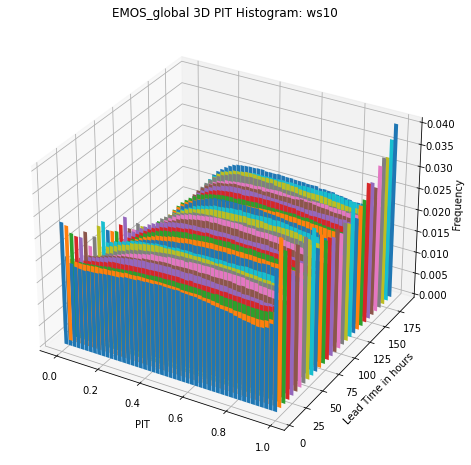

<IPython.core.display.Javascript object>

In [117]:
plot_pit_histogram(
    EMOS_global_ws10_preds, ws10_ground_truth, "EMOS_global 3D PIT Histogram: ws10"
)

### 2. EMOS_local

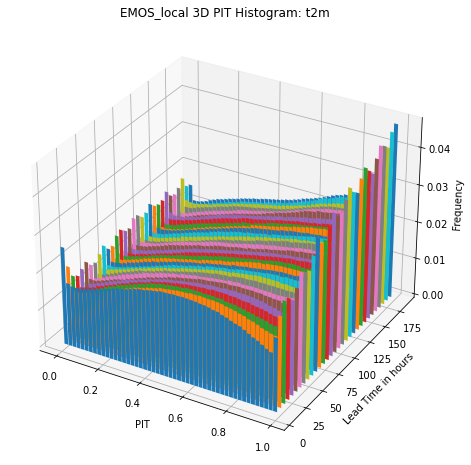

<IPython.core.display.Javascript object>

In [108]:
plot_pit_histogram(
    EMOS_local_t2m_preds, t2m_ground_truth, "EMOS_local 3D PIT Histogram: t2m"
)

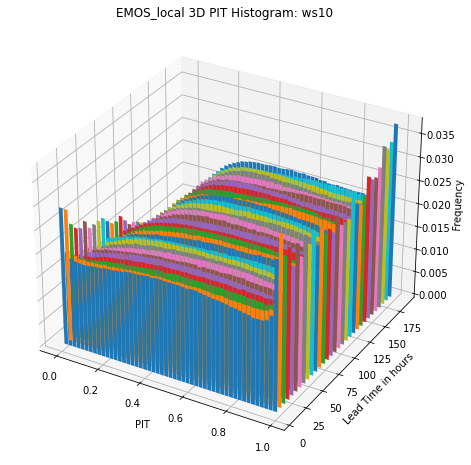

<IPython.core.display.Javascript object>

In [118]:
plot_pit_histogram(
    EMOS_local_ws10_preds, ws10_ground_truth, "EMOS_local 3D PIT Histogram: ws10"
)

### 3. DRN

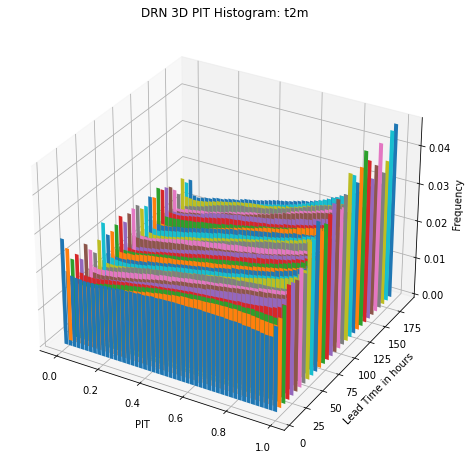

<IPython.core.display.Javascript object>

In [110]:
plot_pit_histogram(DRN_t2m_preds, t2m_ground_truth, "DRN 3D PIT Histogram: t2m")

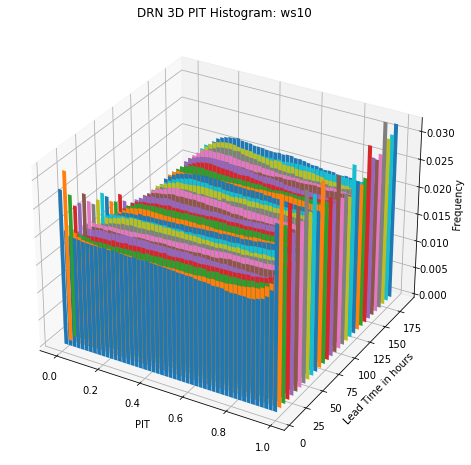

<IPython.core.display.Javascript object>

In [111]:
plot_pit_histogram(DRN_ws10_preds, ws10_ground_truth, "DRN 3D PIT Histogram: ws10")

### 4. U-net

In [14]:
len(u_net_t2m_preds)

31

<IPython.core.display.Javascript object>

In [16]:
u_net_t2m_preds[0].shape

(357, 120, 130, 2)

<IPython.core.display.Javascript object>

In [20]:
test.shape

(357, 120, 130)

<IPython.core.display.Javascript object>

In [30]:
test[0].max()

1.0

<IPython.core.display.Javascript object>

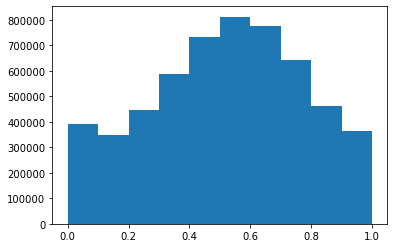

<IPython.core.display.Javascript object>

In [34]:
plt.hist(test[0].flatten())
plt.show()

In [39]:
u_net_t2m_preds[slice(0, 15)],
t2m_ground_truth.isel(lead_time=slice(0, 16))

20

<IPython.core.display.Javascript object>

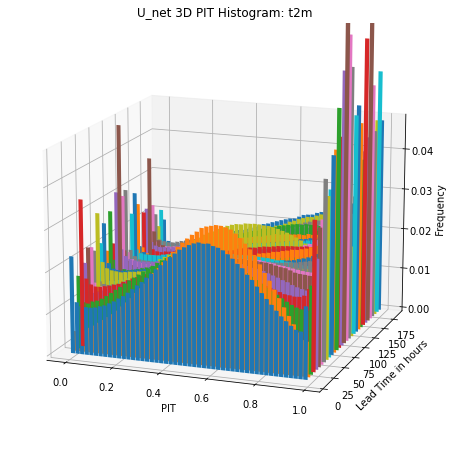

<IPython.core.display.Javascript object>

In [80]:
test = plot_pit_histogram(
    u_net_t2m_preds, t2m_ground_truth, "U_net 3D PIT Histogram: t2m", num_bins=50,
)

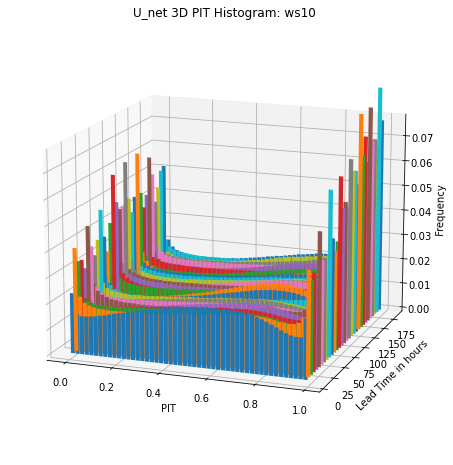

[array([[[0.88169158, 0.79371762, 0.93252262, ..., 0.39391345,
          0.44612332, 0.55723198],
         [0.96960147, 0.7721364 , 0.91596023, ..., 0.58551157,
          0.61926634, 0.77165544],
         [0.59611098, 0.45901218, 0.59575072, ..., 0.28971814,
          0.38491859, 0.50818988],
         ...,
         [0.99105451, 0.9960888 , 0.67961406, ..., 0.28097757,
          0.3184734 , 0.24493602],
         [0.99858098, 0.99807423, 0.48238419, ..., 0.48575746,
          0.5746918 , 0.46448889],
         [0.94486582, 0.83854368, 0.196623  , ..., 0.8479377 ,
          0.64353961, 0.61982354]],
 
        [[0.58366989, 0.76819424, 0.86443242, ..., 0.40022892,
          0.52708605, 0.68054683],
         [0.97950997, 0.88546244, 0.67309106, ..., 0.24517047,
          0.41221933, 0.55206889],
         [0.89250796, 0.80936917, 0.71568957, ..., 0.31986407,
          0.4337347 , 0.3450747 ],
         ...,
         [0.04011859, 0.03732757, 0.12326565, ..., 0.36775538,
          0.40734312, 0.

<IPython.core.display.Javascript object>

In [81]:
plot_pit_histogram(u_net_ws10_preds, ws10_ground_truth, "U_net 3D PIT Histogram: ws10")